In [5]:
# Data manipulation
import numpy as np
import pandas as pd

# For implementing the ARCH model
from arch import arch_model

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
#print("Current Working Directory:", os.getcwd())
#print("Python Path:", sys.path)

In [7]:
# Read the csv file using read_csv method of pandas
SP500_data = pd.read_csv('ASQ_02_data_SP500_data_2019_2020_ARCH.csv', index_col=0)
SP500_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-22,2948.05,2956.76,2933.59,2955.45,2955.45,3952800000
2020-05-26,3004.08,3021.72,2988.17,2991.77,2991.77,5837060000
2020-05-27,3015.65,3036.25,2969.75,3036.13,3036.13,6371230000
2020-05-28,3046.61,3068.67,3023.40,3029.73,3029.73,5402670000
2020-05-29,3025.17,3049.17,2998.61,3044.31,3044.31,7275080000


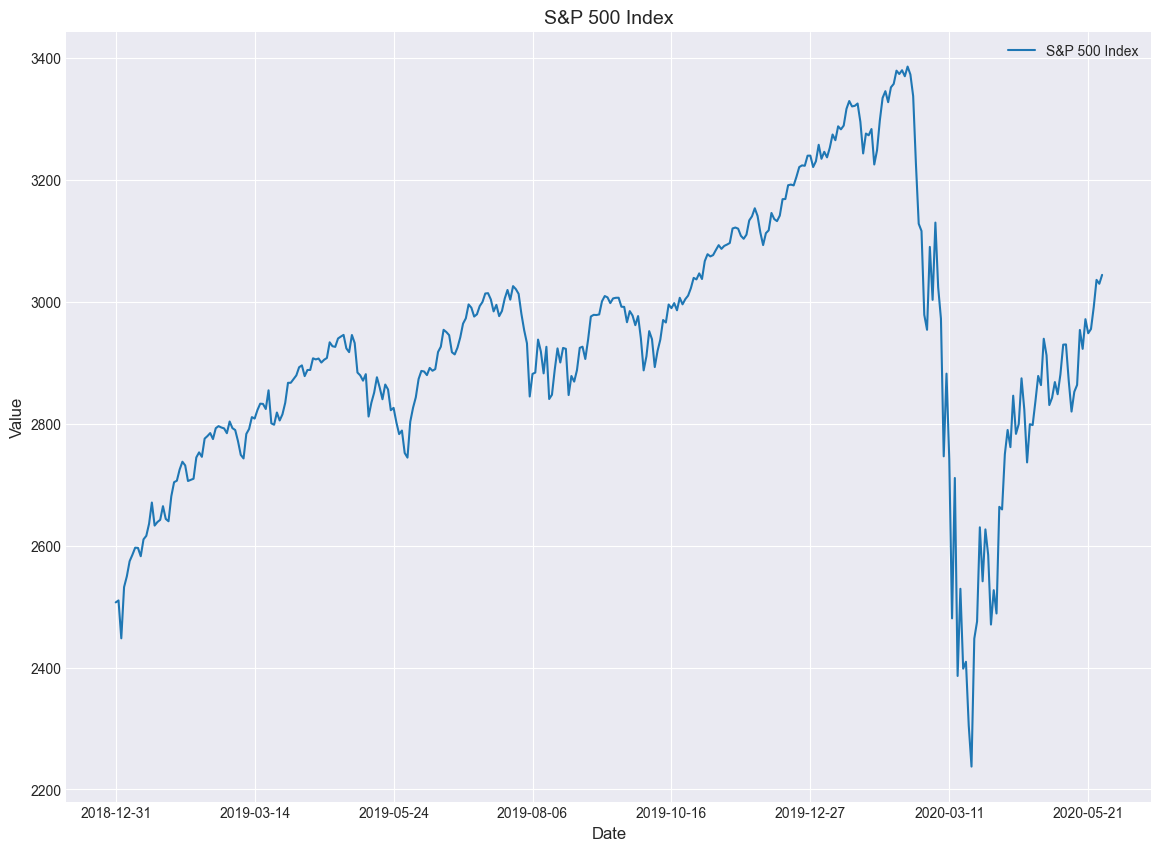

In [8]:
SP500_data['Adj Close'].plot(figsize=(14, 10))
# Set title and labels for the plot
plt.title('S&P 500 Index', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.plot()
plt.legend(['S&P 500 Index'])
plt.show()

In [9]:
SP500_data['log_returns'] = np.log(SP500_data['Adj Close']/SP500_data['Adj Close'].shift(1)) * 100
SP500_data = SP500_data.dropna()

In [10]:
SP500_data.head()

,Open,High,Low,Close,Adj Close,Volume,log_returns
Date,,,,,,,
2019-01-02,2476.96,2519.49,2467.47,2510.03,2510.03,3733160000,0.126772
2019-01-03,2491.92,2493.14,2443.96,2447.89,2447.89,3822860000,-2.506828
2019-01-04,2474.33,2538.07,2474.33,2531.94,2531.94,4213410000,3.375938
2019-01-07,2535.61,2566.16,2524.56,2549.69,2549.69,4104710000,0.698598
2019-01-08,2568.11,2579.82,2547.56,2574.41,2574.41,4083030000,0.964860


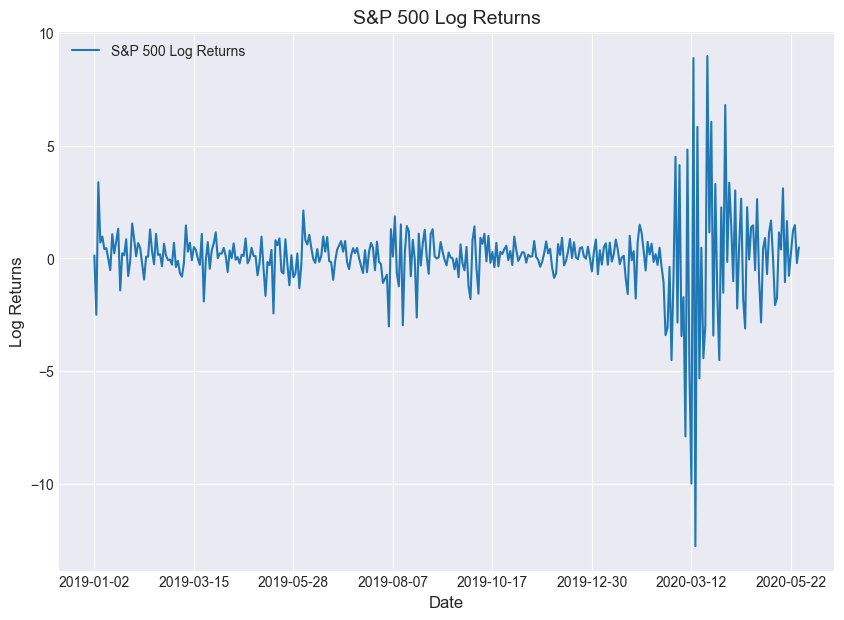

In [11]:
SP500_data['log_returns'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('S&P 500 Log Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(['S&P 500 Log Returns'])
plt.show()

In [12]:
# Annualized volatilty
SP500_data['actual_historical_volatility'] = SP500_data['log_returns'].rolling(14).std() * ((252)**0.5)

# Print the last 5 rows
SP500_data.round(2).tail()

,Open,High,Low,Close,Adj Close,Volume,log_returns,actual_historical_volatility
Date,,,,,,,,
2020-05-22,2948.05,2956.76,2933.59,2955.45,2955.45,3952800000,0.24,23.01
2020-05-26,3004.08,3021.72,2988.17,2991.77,2991.77,5837060000,1.22,23.22
2020-05-27,3015.65,3036.25,2969.75,3036.13,3036.13,6371230000,1.47,23.23
2020-05-28,3046.61,3068.67,3023.40,3029.73,3029.73,5402670000,-0.21,23.16
2020-05-29,3025.17,3049.17,2998.61,3044.31,3044.31,7275080000,0.48,22.39


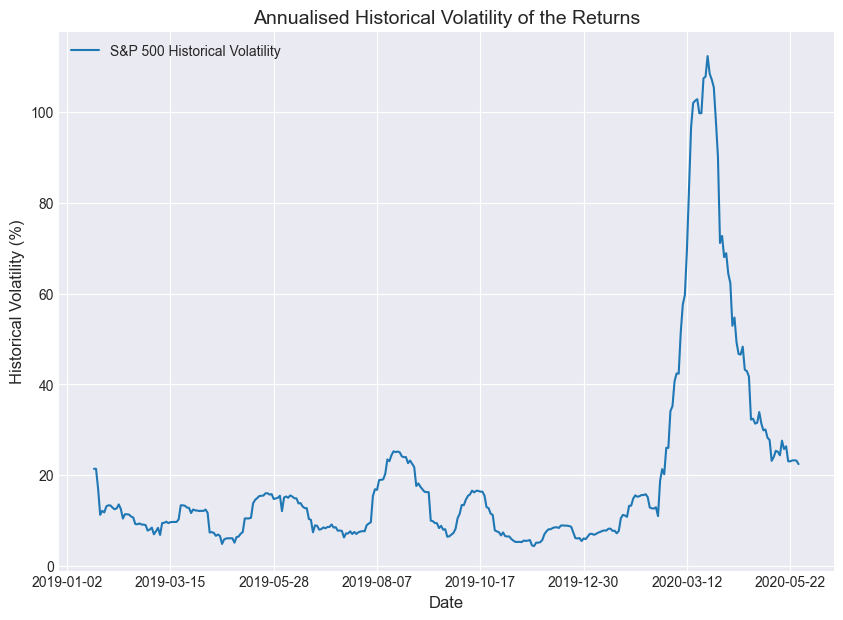

In [13]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('Annualised Historical Volatility of the Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Historical Volatility (%)', fontsize=12)
plt.legend(['S&P 500 Historical Volatility'])
plt.show()

In [14]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='ARCH', p=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecast_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecast volatility
    forecast_volatility = forecast_variance**0.5

    # Calculate and return the annualized forecast variance
    annualized_volatility = forecast_volatility * (252**0.5)
    return annualized_volatility

In [15]:
%%time

# Calculate the ARCH predicted volatility for the each day    
SP500_data['ARCH_predicted_volatility'] = SP500_data['log_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the ARCH predicted volatility to match with the actual historical volatility on each day    
SP500_data['ARCH_predicted_volatility'] = SP500_data['ARCH_predicted_volatility'].shift(1)

CPU times: total: 203 ms
Wall time: 1.48 s


In [16]:
# Showing an example of the normal market scenario
SP500_data[['log_returns','ARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[30:35].round(2)

,log_returns,ARCH_predicted_volatility,actual_historical_volatility
Date,,,
2020-02-14,0.18,11.04,12.84
2020-02-18,-0.29,10.89,12.64
2020-02-19,0.47,11.13,12.61
2020-02-20,-0.38,11.14,12.88
2020-02-21,-1.06,11.29,10.93


In [17]:
# Showing an example of the adverse market scenario
SP500_data[['log_returns','ARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[40:45].round(2)

,log_returns,ARCH_predicted_volatility,actual_historical_volatility
Date,,,
2020-03-02,4.50,13.71,34.08
2020-03-03,-2.85,39.94,35.18
2020-03-04,4.13,29.19,40.64
2020-03-05,-3.45,44.43,42.40
2020-03-06,-1.72,40.93,42.32


# Generalized Autoregressive Conditionally Heteroskedastic Models (GARCH)

In [18]:
import time

In [19]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='GARCH', p=1, q=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecasted_volatility = forecasted_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualised_volatility = forecasted_volatility * (252**0.5)
    return annualised_volatility

In [20]:
start_time = time.time()

# Calculate the GARCH predicted volatility for the each day    
SP500_data['GARCH_predicted_volatility'] = SP500_data['log_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the GARCH predicted volatility to match with the actual historical volatility on each day    
SP500_data['GARCH_predicted_volatility'] = SP500_data['GARCH_predicted_volatility'].shift(1)

end_time = time.time()

In [21]:
print("Time taken to predict volatility using GARCH is", round(end_time - start_time, 2), "seconds.")

Time taken to predict volatility using GARCH is 1.85 seconds.


In [22]:
# Showing an example where the ARCH failed to capture volatility clustering but GARCH captures it well
SP500_data[['log_returns','ARCH_predicted_volatility','GARCH_predicted_volatility', 
            'actual_historical_volatility']].dropna()[65:70].round(2)

,log_returns,ARCH_predicted_volatility,GARCH_predicted_volatility,actual_historical_volatility
Date,,,,
2020-04-06,6.80,28.61,49.66,72.71
2020-04-07,-0.16,107.19,72.06,68.02
2020-04-08,3.35,13.68,61.13,68.90
2020-04-09,1.44,53.13,58.73,64.37
2020-04-13,-1.02,25.15,50.96,62.31


# Comparing ARCH and GARCH forecasts

In [23]:
SP500_data.dropna(inplace=True)

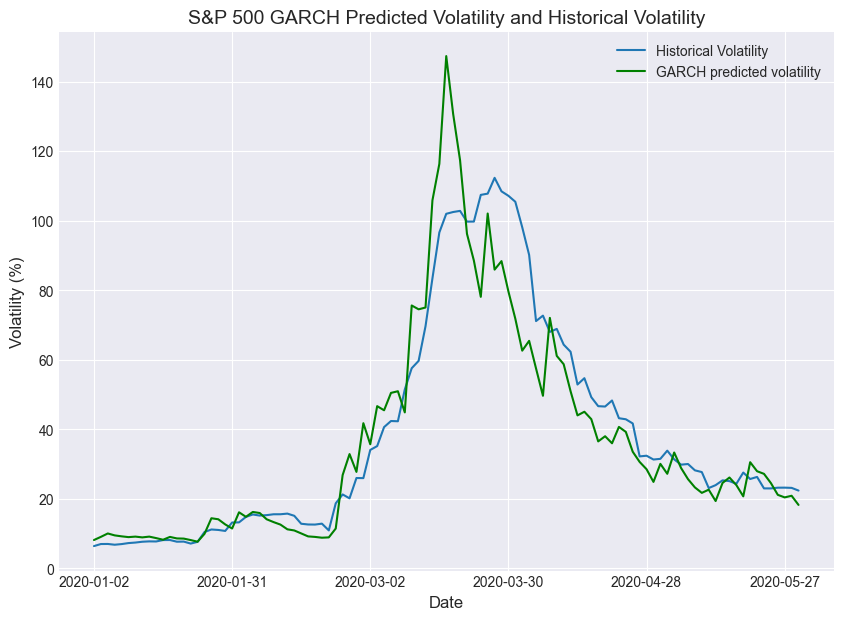

In [24]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
SP500_data['GARCH_predicted_volatility'].plot(figsize=(10, 7), color='green')
# Set title and labels for the plot
plt.title('S&P 500 GARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'GARCH predicted volatility'])
plt.show()

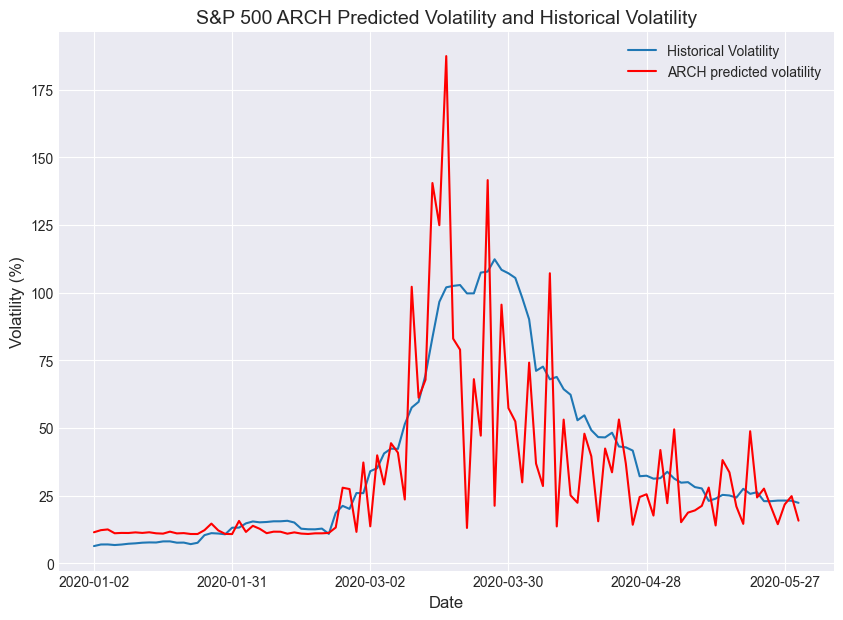

In [25]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
SP500_data['ARCH_predicted_volatility'].plot(figsize=(10, 7), color='red')
# Set title and labels for the plot
plt.title('S&P 500 ARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'ARCH predicted volatility'])
plt.show()